# Chapter 11

## Setup and imports

In [1]:
%load_ext lab_black

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline

## Section 11.1

### Program 11.1

In [4]:
df1 = pd.DataFrame(
    {
        "A": [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        "Y": [200, 150, 220, 110, 50, 180, 90, 170, 170, 30, 70, 110, 80, 50, 10, 20],
    }
)

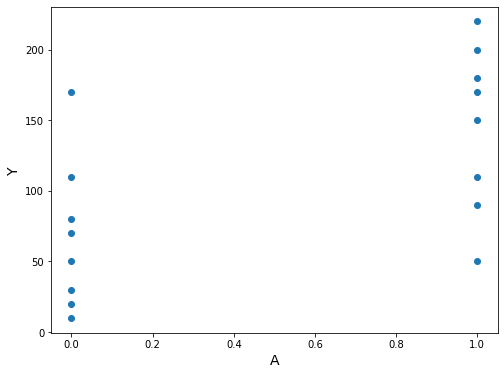

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df1["A"], df1["Y"])
ax.set_xlabel("A", fontsize=14)
ax.set_ylabel("Y", fontsize=14)

In [6]:
df1.groupby("A").describe()

Y                                                     
  count    mean        std   min    25%    50%    75%    max
A                                                           
0   8.0   67.50  53.117121  10.0   27.5   60.0   87.5  170.0
1   8.0  146.25  58.294205  50.0  105.0  160.0  185.0  220.0

"Now suppose treatment A is a polytomous variable that can take 4 possible values"

In [7]:
df2 = pd.DataFrame(
    {
        "A": [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
        "Y": [110, 80, 50, 40, 170, 30, 70, 50, 110, 50, 180, 130, 200, 150, 220, 210],
    }
)

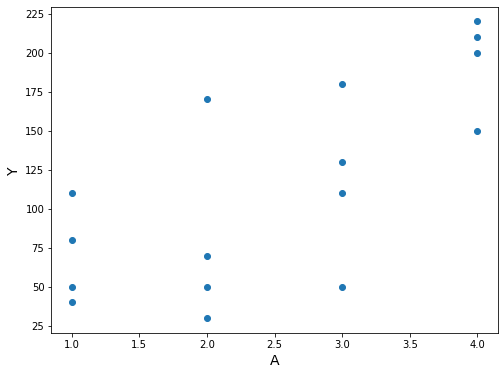

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df2["A"], df2["Y"])
ax.set_xlabel("A", fontsize=14)
ax.set_ylabel("Y", fontsize=14)

In [9]:
df2.groupby("A").describe()

Y                                                     
  count   mean        std    min    25%    50%    75%    max
A                                                           
1   4.0   70.0  31.622777   40.0   47.5   65.0   87.5  110.0
2   4.0   80.0  62.182527   30.0   45.0   60.0   95.0  170.0
3   4.0  117.5  53.774219   50.0   95.0  120.0  142.5  180.0
4   4.0  195.0  31.091264  150.0  187.5  205.0  212.5  220.0

## Section 11.2

### Program 11.2

In [10]:
A, Y = zip(
    *(
        (3, 21),
        (11, 54),
        (17, 33),
        (23, 101),
        (29, 85),
        (37, 65),
        (41, 157),
        (53, 120),
        (67, 111),
        (79, 200),
        (83, 140),
        (97, 220),
        (60, 230),
        (71, 217),
        (15, 11),
        (45, 190),
    )
)

In [11]:
df3 = pd.DataFrame({"A": A, "Y": Y, "constant": np.ones(16)})

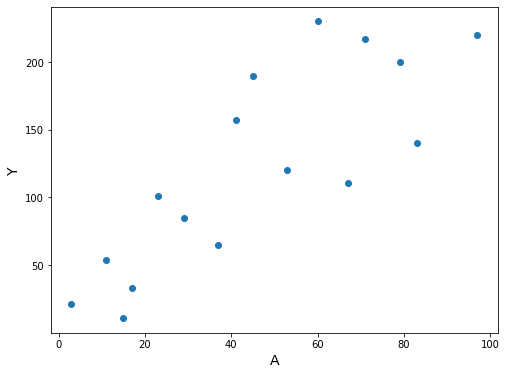

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df3.A, df3.Y)
ax.set_xlabel("A", fontsize=14)
ax.set_ylabel("Y", fontsize=14)

"The values $\hat{\theta}_0$ and $\hat{\theta}_1$ can be easily computed using linear algebra, as described in any statistics textbook."

Briefly, make $X$ be the matrix with ones in the first column and $A$ in the second column, and make $Y$ an $n \times 1$ matrix. Then $\hat{\theta}_0$ and $\hat{\theta}_1$ are calculated as $\hat\theta = (X^TX)^{-1}X^TY$

In [13]:
X = np.ones((df3.shape[0], 2))  # make X a matrix of ones
X[:, 1] = df3.A  # replace second column with A
Y = np.array(df3.Y).reshape((-1, 1))  # make Y an n x 1 matrix

theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
theta

array([[24.54636872],
       [ 2.13715198]])

In [14]:
print("theta0 est.: {:>5.2f}".format(theta[0][0]))
print("theta1 est.: {:>5.2f}".format(theta[1][0]))

theta0 est.: 24.55
theta1 est.:  2.14


In [15]:
expectation_at_90 = theta[0][0] + 90 * theta[1][0]
print("E[Y|A=90] est.: {:>5.1f}".format(expectation_at_90))

E[Y|A=90] est.: 216.9


We can also compute this with a statistics package, like Statsmodels, which will also give us confidence intervals and other values

In [16]:
ols = sm.OLS(Y, df3[["constant", "A"]])
res = ols.fit()

In [17]:
summary = res.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,24.5464,21.330,1.151,0.269,-21.202,70.295
A,2.1372,0.400,5.347,0.000,1.280,2.994


Initially, it wasn't clear how to get confidence intervals for expected values from Statsmodels, so the next cells calculate them from scratch.

In [18]:
n = df3.shape[0]
yvar = (res.resid * res.resid).sum() / (n - 2)  # = res.mse_resid
xval = np.array([[1, 90]])
X = df3[["constant", "A"]]
XpXinv = np.linalg.inv(np.dot(X.T, X))
se_mean = np.sqrt(yvar * np.dot(xval, np.dot(XpXinv, xval.T)))[0, 0]

In [19]:
t = scipy.stats.t.ppf(0.975, n - 2)
ypred = res.predict([[1, 90]])[0]
print("           estimate      95% C.I.")
print(
    "E[Y|A=90]   {:>6.2f}   ({:>6.2f}, {:>6.2f})".format(
        ypred, ypred - t * se_mean, ypred + t * se_mean
    )
)

           estimate      95% C.I.
E[Y|A=90]   216.89   (172.15, 261.63)


Here's an easier way to calculate the confidence intervals, contributed by GitHub user @pettypychen

In [20]:
pred = res.get_prediction(exog=[1, 90])
pred.summary_frame().round(2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,216.89,20.86,172.15,261.63,112.27,321.51


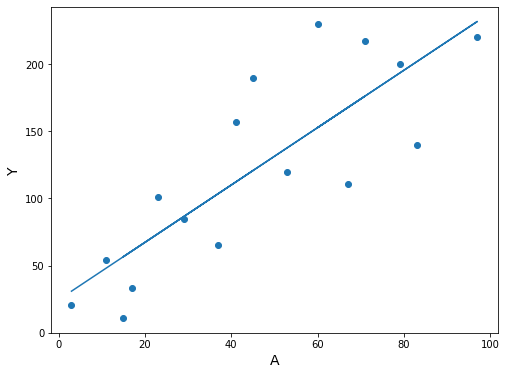

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df3.A, df3.Y)
ax.plot(df3.A, res.predict(df3[["constant", "A"]]))
ax.set_xlabel("A", fontsize=14)
ax.set_ylabel("Y", fontsize=14)

## Section 11.3

(Still Program 11.2)

"Let us return to the data in Figure 11.1."

In [22]:
df1["constant"] = 1

In [23]:
ols = sm.OLS(df1["Y"], df1[["constant", "A"]])
res = ols.fit()

In [24]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,67.5000,19.716,3.424,0.004,25.213,109.787
A,78.7500,27.883,2.824,0.014,18.947,138.553


In [25]:
est_at_0 = res.params[0]
est_at_1 = res.params[0] + res.params[1]
print("E[Y|A=0] est.: {:>6.2f}".format(est_at_0))
print("E[Y|A=1] est.: {:>6.2f}".format(est_at_1))

E[Y|A=0] est.:  67.50
E[Y|A=1] est.: 146.25


## Section 11.4

### Program 11.3

Starting from the same data as Section 11.2, Program 11.2

In [26]:
df3["A^2"] = df3.A * df3.A

In [27]:
ols = sm.OLS(df3.Y, df3[["constant", "A", "A^2"]])
res = ols.fit()

In [28]:
summary = res.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,-7.4069,31.748,-0.233,0.819,-75.994,61.180
A,4.1072,1.531,2.683,0.019,0.800,7.414
A^2,-0.0204,0.015,-1.331,0.206,-0.053,0.013


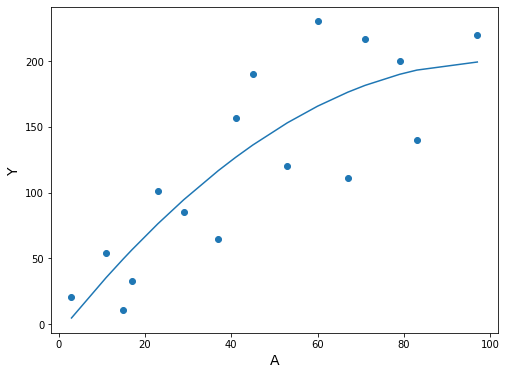

In [29]:
df3.sort_values("A", inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df3.A, df3.Y)
ax.plot(df3.A, res.predict(df3[["constant", "A", "A^2"]]))
ax.set_xlabel("A", fontsize=14)
ax.set_ylabel("Y", fontsize=14)

The expected value and confidence interval can be obtained with the method contributed by @pettypychen above

In [30]:
pred = res.get_prediction(exog=[1, 90, 90 ** 2])
pred.summary_frame().round(2)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,197.13,25.16,142.77,251.49,89.63,304.62
